## Predicting Breast Cancer Risk using Machine Learning 
---
This notebook shows you how we can use exploratory data analysis and machine learning for predicting breast cancers. All our models are built using [Wisconsin Diagnostic Breast Cancer](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/) dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale

sns.set()
%matplotlib inline

### Loading the Dataset

Next, we are going to load the dataset as a Pandas data frame (`DataFrame`). In ML model building, it is the best practice to keep the testing dataset aside and it should not be mixed with training dataset. So as the very first step, we split our dataset into training and testing subsets. 

In [2]:
data = pd.read_csv('./data/data.csv')
data = data.sample(n=len(data))

train_size = int(len(data)*0.8)
test_size = len(data) - train_size

assert len(data) == (train_size + test_size)
print('training dataset size: {}'.format(train_size))
print('testing dataset size: {}'.format(test_size))

train = data.iloc[0:train_size]
test = data.iloc[train_size:]

assert len(data) == len(train) + len(test)

training dataset size: 455
testing dataset size: 114


In [3]:
data['response'] = data['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

In [4]:
train.head(5)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
313    893988         B        11.54         10.72           73.73      409.1   
29     853201         M        17.57         15.05          115.00      955.1   
15   84799002         M        14.54         27.54           96.73      658.8   
261    888264         M        17.35         23.06          111.00      933.1   
18     849014         M        19.81         22.15          130.00     1260.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
313          0.08597           0.05969         0.01367             0.008907   
29           0.09847           0.11570         0.09875             0.079530   
15           0.11390           0.15950         0.16390             0.073640   
261          0.08662           0.06290         0.02891             0.028370   
18           0.09831           0.10270         0.14790             0.094980   

        ...       texture_worst  perimeter_worst  area_worst  \
313     ...               12.87            81.23       467.8   
29      ...               19.52           134.90      1227.0   
15      ...               37.13           124.10       943.2   
261     ...               31.47           128.20      1218.0   
18      ...               30.88           186.80      2398.0   

     smoothness_worst  compactness_worst  concavity_worst  \
313            0.1092             0.1626          0.08324   
29             0.1255             0.2812          0.24890   
15             0.1678             0.6577          0.70260   
261            0.1240             0.1486          0.12110   
18             0.1512             0.3150          0.53720   

     concave points_worst  symmetry_worst  fractal_dimension_worst  \
313               0.04715          0.3390                  0.07434   
29                0.14560          0.2756                  0.07919   
15                0.17120          0.4218                  0.13410   
261               0.08235          0.2452                  0.06515   
18                0.23880          0.2768                  0.07615   

     Unnamed: 32  
313          NaN  
29           NaN  
15           NaN  
261          NaN  
18           NaN  

[5 rows x 33 columns]

### Exploratory Data Analysis and Visualization

Exploratory data analysis helps us to understand the nature of the training dataset. Also, it is a great tool to understands the relationships between different features of the dataset. 

#### Is our dataset balanced?

A bar graph (as shown below) can be used to answer above question. According to our bar graph, it clearly indicates that this is not a completely balanced dataset. But it is not extremely imbalanced, so we can frame predictive model building process as a classification problem. 

**Note**: If this was an extremely imbalanced dataset this problem should be framed as an anomaly detection problem.

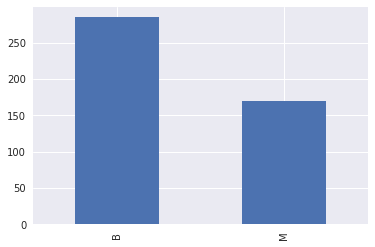

In [5]:
train['diagnosis'].value_counts().plot(kind='bar')

### Various Plots to Identify Good Features and Relationship Between Features

We can use the following three plots to identify quality (in terms of predictive power) features for our model building process. Also, it is worth to note that, for real-world projects, we might use a lot more plots and visualizations than we presented in this notebook.

#### Box Plots

Following box-plots can be used to identify features which are capable of **`discriminating`**  **`malignant`** cells from **`benign`** cells. For instance, **`concave_points_mean`** shows two different distribution for malignant and benign cells. Hence, it will be a **`valuable feature`** when it comes to model building. But, **`symmetry_mean`** is **`not a (so) good feature`** in terms of discriminating malignant and benign cells.

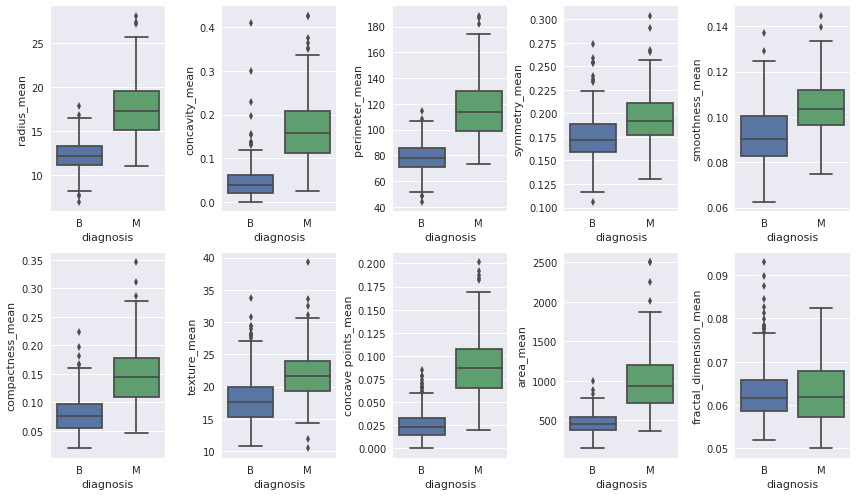

In [6]:
f, axes = plt.subplots(2, 5)
f.set_size_inches(12, 7)
y_names = train.columns[2:12].values

for i in range(len(y_names)):
    sns.boxplot(x='diagnosis', y=y_names[i], data=train, ax=axes[i%2, i%5])
    
plt.tight_layout()
plt.show()

#### Regression Plots

Regression plots can be used to identify the relationship between two features. If there is a relationship (for instance linear) between two variables (for instance: **`area_mean vs radius`** plot is shown below) we can drop one of these two features when we are building models. 

**Note**: following plots show relationships between **`radius_mean`** vs rest of the mean features. (i.e. **`texture_mean`**, **`area_mean`**, and etc.) But in practice, it is worth to check the relationship between all possible feature combinations.

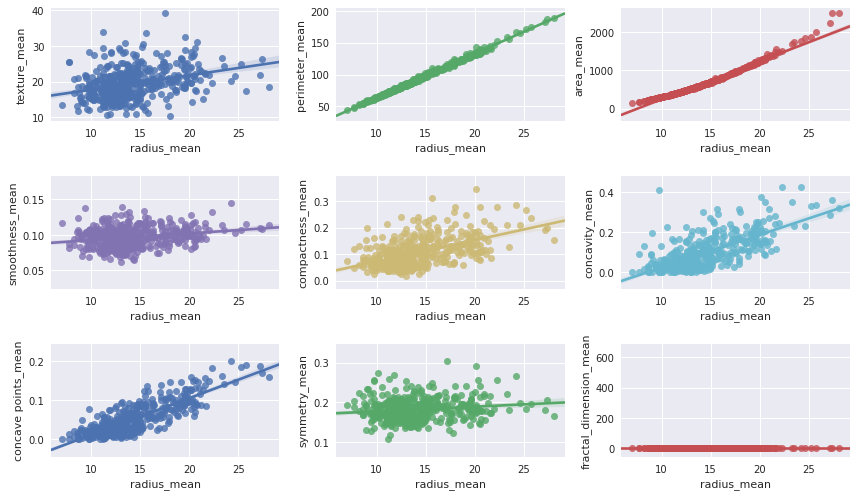

In [7]:
independent = train.columns[2]
dependents =  train.columns[3:12].values

f, axes = plt.subplots(3, 3)
f.set_size_inches(12, 7)

for i in range(len(dependents)):
    sns.regplot(x=independent, y=dependents[i], data=train, ax=axes[i//3, i%3])

plt.tight_layout()
plt.show()

#### Histogram Plots

Histogram and density plots help us to visualize the distribution of values of a single feature.

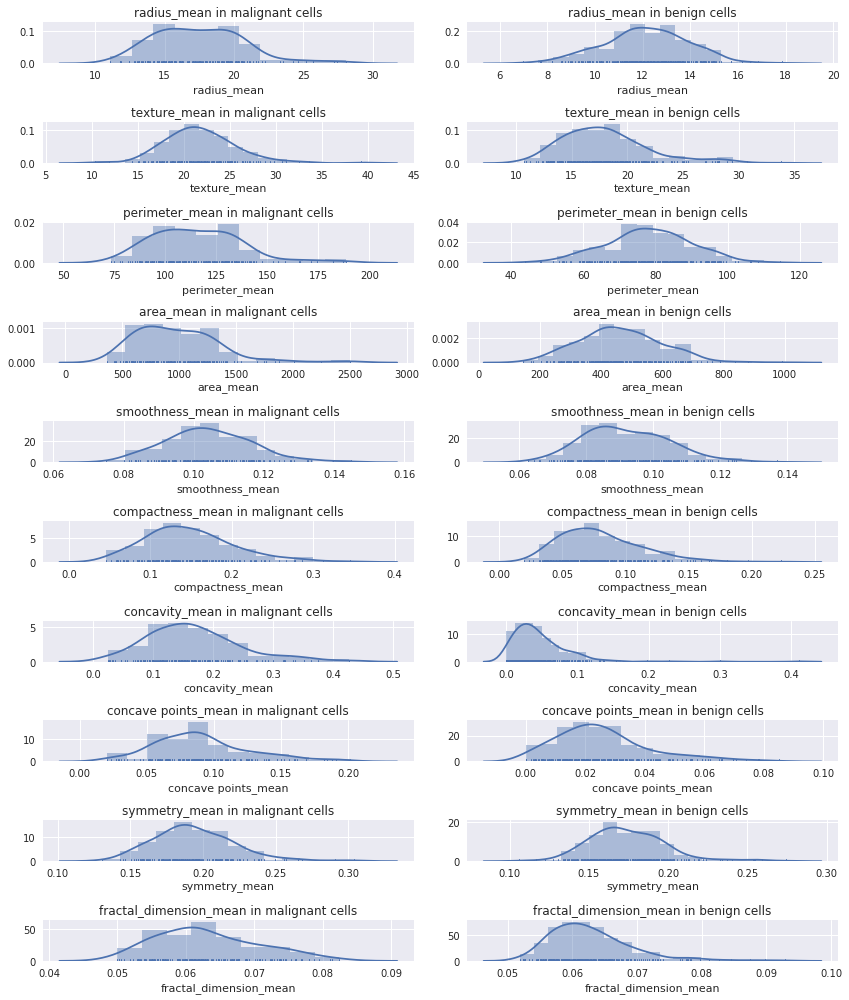

In [8]:
y_names = train.columns[2:12].values
f, axes = plt.subplots(10, 2)
f.set_size_inches(12, 14)

for i in range(len(y_names)):
    axes[i%10, 0].set_title('{} in malignant cells'.format(y_names[i]))
    sns.distplot(train[train['diagnosis'] == 'M'][y_names[i]], kde=True, rug=True, ax=axes[i%10, 0])
    
    axes[i%10, 1].set_title('{} in benign cells'.format(y_names[i]))
    sns.distplot(train[train['diagnosis'] == 'B'][y_names[i]], kde=True, rug=True, ax=axes[i%10, 1])
    
plt.tight_layout()
plt.show()

After completing this simple exploratory data analysis task we would like to draw the following conclusion.

**(Probably) good features** : `radius_mean`, `concavity_mean`, `compactness_mean`, `concave_points_mean`, `area_mean`, `perimeter_mean`

**(Probably) not so good features**: `

This information might be helpful when we are building machine learning models.

### Machine Learning Model Building

Now its time to build some machine learning models. We will start with simple models with few features. But as we progress through the model building process we will explore more advanced models as well. 

#### Logistic Regression

As the initial step, we will create two `Logistic Regression` models.

1. First one will be using all `not so good features`

2. For the second model, we are going to use all `good features`.

In [9]:
%%time

X_train = train[['smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_mean']].values
y_train = train['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_simple = LogisticRegression()
    lr_simple.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_simple.predict(scale(X_test_cv))
    current_accuracy = accuracy_score(y_test_cv, y_predict_cv)
    cv_accuracies.append(current_accuracy)
    print('cross validation accuracy: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average corss validation accuracy: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

cross validation accuracy: 0.791209
cross validation accuracy: 0.868132
cross validation accuracy: 0.857143
cross validation accuracy: 0.791209
cross validation accuracy: 0.835165
---------------------------------------
average corss validation accuracy: 0.828571
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 20 ms


In [10]:
%%time

X_train = train[[ 'radius_mean', 'concavity_mean', 'compactness_mean', 
                 'concave points_mean', 'area_mean', 'perimeter_mean']].values

y_train = train['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_good_features = LogisticRegression()
    lr_good_features.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_good_features.predict(scale(X_test_cv))
    current_accuracy = accuracy_score(y_test_cv, y_predict_cv)
    cv_accuracies.append(current_accuracy)
    print('cross validation accuracy: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average corss validation accuracy: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

cross validation accuracy: 0.912088
cross validation accuracy: 0.934066
cross validation accuracy: 0.901099
cross validation accuracy: 0.912088
cross validation accuracy: 0.945055
---------------------------------------
average corss validation accuracy: 0.920879
CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 17.6 ms


The accuracies clearly indicate that the model which is using good features (`radius_mean`, `concavity_mean`, `compactness_mean`, `concave_points_mean`, `area_mean`, `perimeter_mean`) is performing better than the model which is based on not so good features (`smoothness_mean`, `texture_mean`, `fractal_dimension_mean`, `symmetry_mean`) 

However, it is worth to note that using visualization techniques we can't capture all possible interaction between a set of features. So next I'm going to build a couple of models using all available **`mean`** features we have in our training set.

**Note**: Since this is a very small dataset (in terms of a number of features) I didn't put some effort into feature selection. But, in real-world production quality model development tasks, we might need to use one of the feature selection techniques such as "forward-feature selection" or "backward-feature selection".

In [11]:
%%time

X_train = train[['radius_mean', 'concavity_mean', 'compactness_mean', 
                 'concave points_mean', 'area_mean', 'perimeter_mean', 
                  'smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_mean']].values

y_train = train['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_all = LogisticRegression()
    lr_all.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_all.predict(scale(X_test_cv))
    current_accuracy = accuracy_score(y_test_cv, y_predict_cv)
    cv_accuracies.append(current_accuracy)
    print('cross validation accuracy: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average corss validation accuracy: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

cross validation accuracy: 0.934066
cross validation accuracy: 0.978022
cross validation accuracy: 0.890110
cross validation accuracy: 0.934066
cross validation accuracy: 0.912088
---------------------------------------
average corss validation accuracy: 0.929670
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.2 ms


In [12]:
%%time
from sklearn.ensemble import RandomForestClassifier

X_train = train[['radius_mean', 'concavity_mean', 'compactness_mean', 
                 'concave points_mean', 'area_mean', 'perimeter_mean', 
                  'smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_mean']].values

y_train = train['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    gbc = RandomForestClassifier(n_estimators=2500)
    gbc.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = gbc.predict(scale(X_test_cv))
    current_accuracy = accuracy_score(y_test_cv, y_predict_cv)
    cv_accuracies.append(current_accuracy)
    print('cross validation accuracy: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average corss validation accuracy: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

cross validation accuracy: 0.956044
cross validation accuracy: 0.967033
cross validation accuracy: 0.912088
cross validation accuracy: 0.923077
cross validation accuracy: 0.912088
---------------------------------------
average corss validation accuracy: 0.934066
CPU times: user 25.2 s, sys: 281 ms, total: 25.4 s
Wall time: 27.1 s


In [13]:
%%time
from sklearn.svm import SVC

X_train = train[['radius_mean', 'concavity_mean', 'compactness_mean', 
                 'concave points_mean', 'area_mean', 'perimeter_mean', 
                  'smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_mean']].values

y_train = train['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    svc = SVC(C=10.4)
    svc.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = svc.predict(scale(X_test_cv))
    current_accuracy = accuracy_score(y_test_cv, y_predict_cv)
    cv_accuracies.append(current_accuracy)
    print('cross validation accuracy: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average corss validation accuracy: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

cross validation accuracy: 0.956044
cross validation accuracy: 0.945055
cross validation accuracy: 0.945055
cross validation accuracy: 0.934066
cross validation accuracy: 0.956044
---------------------------------------
average corss validation accuracy: 0.947253
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 22.4 ms


Now we developed several models and their accuracies are given below.

| Algorithm        | Accuracy           | 
| :------------- |:-------------|
| LogisticRegression      | ~0.929670 | 
|RandomForestClassifier     | ~0.934066      |  
| Support Vector Classifier (SVC)| ~0.947253     |   


### Answers to the Questions

1. Actually, this is a very small dataset and without much effort, we managed to develop a model with ~94.7 percent of validation accuracy. When it comes to challenges, I think the main challenge is the size of the dataset. It is very small (when it compares with typical datasets we use for real-world ML tasks). Hence, we could not go for more expressive ML models.

2. We trained four machine learning models and their details are given above.

3. When it comes to handling missing values the easiest (and also most naive) approach is dropping data rows which contain missing values. However, if we have very small dataset this may not practical. So in such cases, we can use following methods.

    1. **Impute missing values with mean**: Usually, this is suitable for numerical features. 
    
    2. **Impute missing values with median**: This approach is more appropriate for categorical features.
    
    3. **EM algorithm based approaches**: Bit advanced but very useful tool for missing value imputation.

Finally, we run our best machine learning model (SVC) against the testing dataset.

In [14]:
X_test = test[['radius_mean', 'concavity_mean', 'compactness_mean', 
                 'concave points_mean', 'area_mean', 'perimeter_mean', 
                  'smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_mean']].values

y_test = test['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values

cls = SVC(C=10.4)
cls.fit(scale(X_train), y_train)

y_pred = cls.predict(scale(X_test))

print('Testing accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix: \n')
print(confusion_matrix(y_test, y_pred))

Testing accuracy: 0.9211
Confusion matrix: 

[[68  4]
 [ 5 37]]


### Discussion

So we would like to mention following points in order to further increase our prediction accuracies.

1.  We didn't try hyper-parameters optimization techniques in the exercise. It is a well-known fact that proper hyper-parameter optimization helps to further increase prediction accuracies. 

2. We didn't try `*_worst` and `*_standard_error` features. It is worth to test how these features affect accuracies of our models.

3. Finally, if we can find more training data, we can try more advanced algorithms such as deep neural networks.
